<a href="https://colab.research.google.com/github/yunwilliamyu/SlowMoMan/blob/master/Gaussian_minimizer_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gaussian minimizer density experiments

Code associated with experiments/figures for the manuscript "*On minimizers and convolutional filters: a partial justification for the effectiveness of CNNs in categorical sequence analysis*" by Yun William Yu. [arXiv:2111.08452](https://arxiv.org/abs/2111.08452)

In [4]:
pip install mmh3 # Using fast Murmurhash library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.5 MB/s 


## Helper functions

In [5]:
import string
import re
import numpy as np

def random_string(n=10**6):
  '''generates a random genomic sequence'''
  ans = ''.join([str(x) for x in list(np.random.randint(4,size=n))])
  ans = ans.replace('0', 'A')
  ans = ans.replace('1', 'C')
  ans = ans.replace('2', 'G')
  ans = ans.replace('3', 'T')
  return ans

def preprocess_string(x):
  '''strip out any characters other than A, C, G, or T'''
  allow = "ACGT"
  return re.sub('[^%s]' % allow, '', x.upper())

def kmers(x,k):
  '''get kmers from preprocesssed string as a generator'''
  for i in range(len(x)-k+1):
    yield x[i:i+k]
  return

def onehot(x):
  '''Returns one-hot encoding of A,C,G,T string'''
  ans = np.zeros(len(x)*4)
  for i, c in enumerate(x):
    if c == 'A':
      ans[4*i] = 1
    elif c =='C':
      ans[4*i+1] = 1
    elif c =='G':
      ans[4*i+2] = 1
    elif c =='T':
      ans[4*i+3] = 1
    else:
      raise ValueError('Strings must only contain A, C, G, T. Please preprocess_string first')
  return ans

class cnn_filter:
  '''This class initializes a random Gaussian hash function for DNA sequences'''
  def __init__(self, k):
    '''k is k-mer size'''
    self.k = k
    self.constants = np.random.randn(k*4)
  def hash(self, x, signed=True):
    ox = onehot(x)
    ans = np.dot(ox, self.constants)
    if signed==False:
      ans = 1000*self.k + ans
    return ans


import mmh3
def minimizers(x, k, w, hash_choice=mmh3):
  '''Use Murmurhash 3 to get minimizers of x with k-mer size k with window size w
     For ease of programming, we're actually getting minimziers
  '''
  gen = kmers(x, k)
  kmer_cache = [None]*w
  hash_cache = np.ones(w)*(0)
  loc_cache = np.ones(w)*(0)
  i = -1
  last_minimizer = (None, 0, 0)
  for x in gen:
    i = i+1
    kmer_cache[i%w] = x
    hash_cache[i%w] = hash_choice.hash(x, signed=False)
    loc_cache[i%w] = i
    min_loc = np.argmin(hash_cache)
    curr_minimizer = (kmer_cache[min_loc], hash_cache[min_loc], loc_cache[min_loc])
    if curr_minimizer != last_minimizer:
      last_minimizer = curr_minimizer
      yield curr_minimizer
  return 0

import collections
def frequencies(x, k):
  '''Computes the k-mer frequencies for string x'''
  gen = kmers(x, k)
  result = collections.Counter(gen)
  return result

def hamming(x, y):
  '''Computes Hamming distances for two equal-length strings'''
  return sum(chx != chy for chx, chy in zip(x,y))

def avg_distances(list1, opt_list2 = []):
  '''Computes avg of all pairwise Hamming distances between unique words'''
  if opt_list2 == []:
    list2 = list1
  else:
    list2 = opt_list2
  list1 = list(set(list1))
  list2 = list(set(list2))
  l1 = len(list1)
  l2 = len(list2)
  score = 0
  for i in range(l1):
    for j in range(l2):
      score = score + hamming(list1[i], list2[j])
  return score / (l1*l2)

def mutate_string(x, theta):
  '''Randomly mutates a string into other characters'''
  y = list(x)
  s = np.random.uniform(0,1,size=len(x)) < theta
  r = random_string(len(x))
  for i in range(len(y)):
    if s[i]:
      y[i] = r[i]
  return ''.join(y)


def experiment(k=8, w=16, n=12, N=500, mut_rate=0.02):
  '''Runs a single experiment and keeps track of density and distances'''
  example1 = random_string(n)
  example = ""
  r = int(np.ceil(N/n))
  for i in range(r):
    example = example + mutate_string(example1, mut_rate)
  example = example[:N]
  cnn_hash = cnn_filter(k)

  freq = frequencies(example, k)
  cnn_mins = minimizers(example, k, w, hash_choice=cnn_hash)
  rand_mins = minimizers(example, k, w, hash_choice=mmh3)

  rand_mins_list = [x for x in rand_mins]
  hist_rand = collections.Counter([freq[x] for x, s, _ in rand_mins_list])
  rand_vals = np.asarray((sum(hist_rand.values()),#0,0)
               avg_distances([x for x,y,_ in rand_mins_list]),
               avg_distances([x for x,y,_ in rand_mins_list], list(freq.keys()))))

  cnn_mins_list = [x for x in cnn_mins]
  hist_cnn = collections.Counter([freq[x] for x, s, _ in cnn_mins_list])
  cnn_vals = np.asarray((sum(hist_cnn.values()),#0,0)
              avg_distances([x for x,y,_ in cnn_mins_list]),
              avg_distances([x for x,y,_ in cnn_mins_list], list(freq.keys()))))
  return (rand_vals, cnn_vals)

## Experiments
The code below runs all of the experiments. The "num_data_points_per_dot" parameter controls how many repetitions are done. In the paper, we set the parameter to 400. Below, we have set the default to 25, as that will complete in a few minutes. Setting it to 400 may take upwards of an hour to complete.

In [12]:
num_data_points_per_dot = 25

results_table = []
for n in range(1,30):
  rvs = []
  cvs = []
  for i in range(num_data_points_per_dot):
    rv, cv = experiment(k=8, w=19,n=n, N=1007, mut_rate=0.133333)
    rvs.append(rv)
    cvs.append(cv)
    #if i%10 == 0:
      #print(i)
  output = np.concatenate(([n], sum(rvs)/len(rvs), np.std(rvs, axis=0)/np.sqrt(len(rvs)), sum(cvs)/len(cvs), np.std(cvs, axis=0)/np.sqrt(len(cvs))))
  results_table.append(output)
  #out_format = np.array_repr(output).replace('\n', '')
  print(list(output))

[1.0, 112.4, 2.9495880527088385, 3.262884920099158, 2.2285421243494588, 0.04067311275758261, 0.02784114171032335, 112.52, 2.8460043461002136, 3.3192327310689067, 2.1741168321872673, 0.04390445956778059, 0.02481689777622348]
[2.0, 113.68, 4.382920810685566, 4.578230869704175, 1.3991082874459717, 0.16330609185574996, 0.1463152363256728, 111.0, 3.427931266466753, 4.605027877611549, 2.2285421243494588, 0.17111989087819232, 0.1455433186364327]
[3.0, 106.56, 5.019636236859511, 5.226190251245966, 2.026291193288862, 0.11317344364582835, 0.11239711635695697, 99.68, 3.670697836768494, 5.257477024208859, 1.8458342287431992, 0.15038564256001047, 0.10985992161520206]
[4.0, 103.2, 5.039380226036041, 5.235385398150608, 1.0023971268913336, 0.10049289717355905, 0.09616047376525498, 103.68, 4.029298665450907, 5.2626917514648754, 1.6596095926452101, 0.14223512953293993, 0.09376590234664192]
[5.0, 102.96, 5.227699715577148, 5.383310135676616, 1.41022551388067, 0.08651686023200955, 0.08629045852725317, 102

You can set the below comment from "False" to "True" to use a cached value of the results_table, run with 400-time repetition. This is the actual data used in Figure 2 of the manuscript.

In [16]:
if False:
  results_table = [[1.0, 113.5325, 2.9648957817764705, 3.274724422860227, 0.6011737347680783, 0.012929991113581289, 0.007806365569198388, 112.4825, 2.837194156852359, 3.3307075024154034, 0.5532623558267814, 0.012020988081005702, 0.006696591361744396],
  [2.0, 114.9675, 4.320736024912923, 4.518130528693482, 0.47249720567956793, 0.04332606559410465, 0.039316561522897635, 108.635, 3.344046826724135, 4.562914462468855, 0.5363692175171876, 0.03994833764975197, 0.03889569744868257],
  [3.0, 105.6225, 4.823937459256455, 5.010686854492899, 0.47087682505619244, 0.032342393805537835, 0.030860468360104903, 101.53, 3.6518536410129996, 5.043007519104691, 0.5011713778738766, 0.04129740998668696, 0.030234506364479784],
  [4.0, 106.615, 5.027234272344045, 5.210644649101122, 0.43602401023338133, 0.028608480276806413, 0.027381048833397592, 104.415, 3.760970061373335, 5.237882814354646, 0.3932803548360889, 0.04112125803374272, 0.026794548074616936],
  [5.0, 104.905, 5.17600994310616, 5.333334047457352, 0.3952877907297415, 0.024344613267939172, 0.022971300442740778, 101.94, 3.853672570033209, 5.357473502201135, 0.3433889922522269, 0.03537949242392659, 0.02232447157029273],
  [6.0, 96.82, 5.311781850587892, 5.467461236054672, 0.46251378357839246, 0.020083729216649988, 0.018840014741716975, 90.5525, 3.959725865953553, 5.48570913001251, 0.4190532297632368, 0.03757717964252593, 0.018473187252928656],
  [7.0, 99.4525, 5.383771397337974, 5.530989843311522, 0.34576995152123907, 0.018901570451379284, 0.018025110498188793, 98.0925, 4.06155955653989, 5.551762225464696, 0.30930948801321956, 0.03542524410770882, 0.017814317728890243],
  [8.0, 95.2225, 5.427176135611754, 5.5751181551681555, 0.3642217516500078, 0.015603027308181305, 0.014790568875073847, 90.665, 4.086364552153044, 5.594463906955654, 0.3606514071787327, 0.03290195176598751, 0.014084868218446983],
  [9.0, 93.2375, 5.483934588206008, 5.626913010545269, 0.4003001803334595, 0.015085105297214999, 0.014413033059604757, 84.315, 4.139024829706546, 5.644069783991332, 0.3976832124945685, 0.03437478845848385, 0.014254243971882654],
  [10.0, 100.42, 5.530850123589255, 5.664813895688526, 0.3058537232076798, 0.013925981523284083, 0.013010072250588606, 99.58, 4.317283788718873, 5.681368064970655, 0.21005118423850905, 0.028262777210787255, 0.012646022423500932],
  [11.0, 98.8875, 5.558841564705926, 5.683201131338468, 0.3143041669704684, 0.012325095747738254, 0.011920879817973355, 96.12, 4.358257952116028, 5.698862172566947, 0.32500230768411453, 0.02463705728234305, 0.01155333579865472],
  [12.0, 97.475, 5.598301527089421, 5.723445671186325, 0.345558877038342, 0.011483334732439624, 0.011083252836457695, 92.675, 4.369718319250632, 5.736694143851755, 0.33970345523706424, 0.02740598863696031, 0.011129423975039592],
  [13.0, 95.8475, 5.6078490467565505, 5.734203392373919, 0.3026311440929371, 0.010992617665499043, 0.010285133668691066, 90.0975, 4.39733295286671, 5.751012374285616, 0.347195887612454, 0.02414029641743307, 0.010351423245418828],
  [14.0, 95.2925, 5.618350455889465, 5.744063106419599, 0.31494818522258555, 0.009789472152596412, 0.009165548059711388, 86.735, 4.372529551077975, 5.759871989323927, 0.3714827553198128, 0.024441623711656618, 0.009414695090434754],
  [15.0, 93.41, 5.635947126197371, 5.7579759379867745, 0.29954924469943184, 0.009900483135481936, 0.009539332649608507, 84.2225, 4.4411682607739404, 5.77517164465334, 0.36487324425750933, 0.025135375536655243, 0.009838811514118596],
  [16.0, 92.22, 5.662998676240766, 5.787841747617652, 0.32065012084825406, 0.008955834422681419, 0.00841063922095962, 81.8975, 4.4199635032661, 5.8038558366869415, 0.411998160645166, 0.025876202856115638, 0.008745783285629735],
  [17.0, 91.2875, 5.659786356215663, 5.782708976730499, 0.2927236057700164, 0.009208828254611577, 0.0084440452301103, 79.0275, 4.394848886587987, 5.80794644306913, 0.392210860858034, 0.025199138969716504, 0.008169527596030181],
  [18.0, 90.93, 5.680982416678429, 5.803462041732182, 0.31440459602238613, 0.00793359703819414, 0.0071774054038517, 77.69, 4.429706964262686, 5.8183501106926885, 0.4230806660673587, 0.025432478949715683, 0.007515814875898477],
  [19.0, 90.4525, 5.689037499634585, 5.812344282172813, 0.3393108595005471, 0.00801011210706009, 0.007097172741794039, 75.6175, 4.413492105151678, 5.824367699822517, 0.38910536410463425, 0.024037053866667633, 0.0074758222050012105],
  [20.0, 99.49, 5.703643142313142, 5.812674650746496, 0.2374073503495627, 0.008189442994288544, 0.007772691515240381, 99.19, 4.656828948722265, 5.816297169432769, 0.18030460337994686, 0.016684167705509467, 0.008023914128326837],
  [21.0, 98.5525, 5.713885210176658, 5.826052121588821, 0.2894488026836526, 0.007473389446065034, 0.006681013187653137, 98.7725, 4.6956059148215425, 5.83434674731832, 0.36202811959155845, 0.016604306117382835, 0.00674872258096673],
  [22.0, 98.9825, 5.721984210480539, 5.8382099168623345, 0.334448029408158, 0.007227899327772838, 0.006568298567988564, 99.1975, 4.699647985752863, 5.848412241091456, 0.4890385816834907, 0.01797699200150174, 0.006806531823302572],
  [23.0, 98.7875, 5.7404632737805255, 5.848232517997059, 0.32879455496555904, 0.006770093640721071, 0.0062143817820938295, 99.8425, 4.751160427270456, 5.857294809595553, 0.5661772994168874, 0.0164208320760961, 0.006238916813977645],
  [24.0, 99.0975, 5.743678413626766, 5.853247318313333, 0.3359612840417777, 0.006873026727796968, 0.00641671740319686, 99.72, 4.792342492207424, 5.869957858191936, 0.6417779989996539, 0.016630756722492628, 0.006806520421456523],
  [25.0, 99.27, 5.738928105047251, 5.841013676076585, 0.35845885398466565, 0.007085789790619595, 0.006518243464562883, 99.515, 4.746443465023765, 5.852278106894661, 0.6888664148439811, 0.01730806013549218, 0.006872113493753271],
  [26.0, 98.5175, 5.748313795493391, 5.85223604374951, 0.35926902785377984, 0.006279871088809727, 0.005710079059914195, 99.2175, 4.7707208043483345, 5.859162761232373, 0.7221152846845162, 0.016227170325355336, 0.0062144340646928435],
  [27.0, 98.99, 5.768166980699875, 5.870730180045479, 0.38895661711815643, 0.00558192964587125, 0.005121746008734317, 100.0925, 4.826829148799998, 5.8782277220060815, 0.7652678350584197, 0.015010439847926974, 0.005242616819819807],
  [28.0, 98.9625, 5.761362291034126, 5.866181349797247, 0.367988089990695, 0.005699314621854568, 0.005150145781430878, 98.9275, 4.811437530977558, 5.873509983703243, 0.7604229805673944, 0.015605016827570461, 0.005334949765826987],
  [29.0, 99.065, 5.7592900205082005, 5.863646135337295, 0.38725242090915335, 0.0057213497016018, 0.005193841833258946, 98.7525, 4.814507166927077, 5.871824848541195, 0.7259670167266556, 0.014444791961502649, 0.0053062326298909095]]

## Plotting Figure 2 of manuscript

Text(0.5, 1.0, 'Average distance from all k-mers')

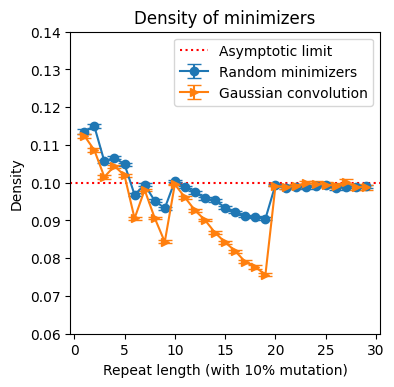

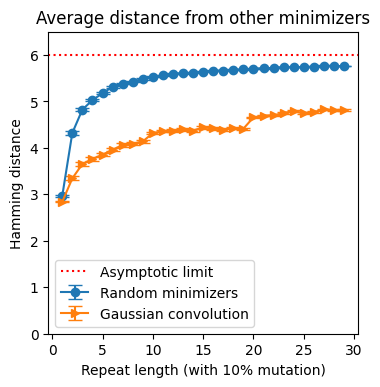

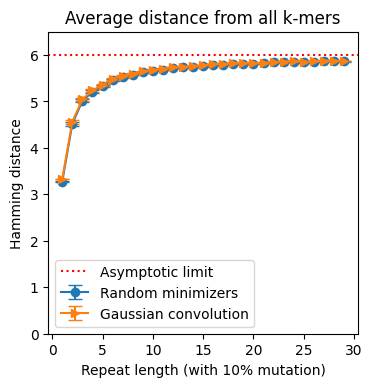

In [17]:
import matplotlib.pyplot as plt
res = np.vstack(results_table)
fig = plt.figure(figsize=(4, 4), dpi=100)
plt.axhline(0.1, color='r', linestyle=':', label='Asymptotic limit')
plt.errorbar(res[:,0], res[:,1]/1000, res[:,4]/1000, fmt='o-', capsize=5, label='Random minimizers')
plt.errorbar(res[:,0], res[:,7]/1000, res[:,10]/1000, fmt='>-', capsize=5, label='Gaussian convolution')
plt.legend()
plt.ylim([0.06, 0.14])
plt.ylabel('Density')
plt.xlabel('Repeat length (with 10% mutation)')
plt.title('Density of minimizers')

fig = plt.figure(figsize=(4, 4), dpi=100)
plt.axhline(6, color='r', linestyle=':', label='Asymptotic limit')
plt.errorbar(res[:,0], res[:,2], res[:,5], fmt='o-', capsize=5, label='Random minimizers')
plt.errorbar(res[:,0], res[:,8], res[:,11], fmt='>-', capsize=5, label='Gaussian convolution')
plt.legend()
plt.ylim([0, 6.5])
plt.ylabel('Hamming distance')
plt.xlabel('Repeat length (with 10% mutation)')
plt.title('Average distance from other minimizers')

fig = plt.figure(figsize=(4, 4), dpi=100)
plt.axhline(6, color='r', linestyle=':', label='Asymptotic limit')
plt.errorbar(res[:,0], res[:,3], res[:,6], fmt='o-', capsize=5, label='Random minimizers')
plt.errorbar(res[:,0], res[:,9], res[:,12], fmt='>-', capsize=5, label='Gaussian convolution')
plt.legend()
plt.ylim([0, 6.5])
plt.ylabel('Hamming distance')
plt.xlabel('Repeat length (with 10% mutation)')
plt.title('Average distance from all k-mers')
